In [1]:
import glob
import hashlib
import json
import math
import os
import random
import copy
import shutil
import time
from itertools import repeat
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import ndimage
from scipy.stats import pearsonr
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.util import *
from skimage import transform
import cv2
import logging
import numpy as np
import torch
import torch.nn.functional as F
from PIL import ExifTags, Image, ImageOps, ImageDraw, ImageFont
from torch.utils.data import DataLoader, Dataset, dataloader, distributed
import torchvision
from tool.utils import *
from IPython.display import clear_output
from skmultilearn.model_selection import IterativeStratification

In [2]:
###########################################################################################
## params...
###########################################################################################
path = './images'
IMG_FORMATS = ['bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp'] 
#CLASS_NAMES = ['band neutrophil', 'segmented neutrophil', 'basophil', 'eosinophil', 'monocyte', 'lymphocyte', 'myelocyte', 'metamyelocyte', 'polychromatic normoblast', 'orthochromatic normoblast', 'splenic marginal zone lymphoma', 'sezary syndrome', 'reactive lymphocyte', 'prolymphocytic leukemia', 'mantle cell lymphoma', 'large granular lymphocytic leukemia', 'hairy cell leukemia', 'follicular lymphoma', 'chronic lymphocytic leukemia', 'peripheral T cell lymphoma', 'burkitts lymphoma', 'diffuse large cell lymphoma', 'waldenstrom macroglobulinemia']
CLASS_NAMES = ['band neutrophil', 'basophil', 'chronic lymphocytic leukemia', 'eosinophil', 'follicular lymphoma', 'hairy cell leukemia', 'large granular lymphocytic leukemia', 'lymphocyte', 'mantle cell lymphoma', 'monocyte', 'prolymphocytic leukemia', 'reactive lymphocyte', 'segmented neutrophil', 'sezary syndrome', 'splenic marginal zone lymphoma']
###########################################################################################
## Read caches...
###########################################################################################
f = []  # image files
for p in path if isinstance(path, list) else [path]:
    p = Path(p)
    f += glob.glob(str(p / '**' / '*.*'), recursive=True)
img_files = sorted(x.replace('/', os.sep) for x in f if x.split('.')[-1].lower() in IMG_FORMATS)
label_files = img2label_paths(img_files)  # labels

###########################################################################################
## load data (1~3 mins)
###########################################################################################
label_all = []
ins_dist = np.zeros((len(CLASS_NAMES),1),dtype=np.float)
ind_dist = np.zeros((len(img_files),len(CLASS_NAMES)),dtype=np.float)
for sample in range(len(img_files)):
    # read
    _, labels = read_data(img_files,label_files,subj_index=sample)

    if labels.ndim == 1: 
        labels = labels.reshape(1,-1)
    for ins in range(np.shape(labels)[0]):
        ind_dist[ sample , int(labels[ins,0]) ] += 1
    ins_dist += ind_dist[sample,:].reshape(-1,1)
    label_all.append(labels)
    

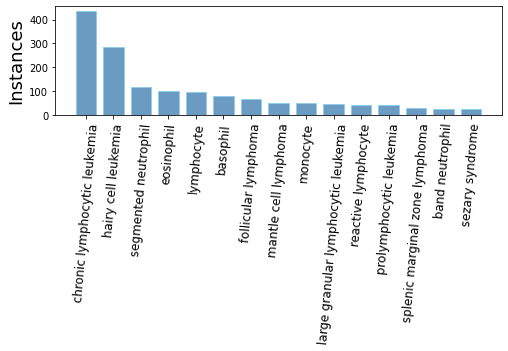

From 606 images:
Total of 1496 instances.


In [3]:
###########################################################################################
## original instance distribution
###########################################################################################
ins_dist = ins_dist.reshape(-1,).astype(np.int)
nc = ins_dist.size
idx = np.argsort(-ins_dist)
names = [CLASS_NAMES[i] for i in idx]

plt.figure(figsize=(8,2))
plt.bar(np.arange(nc),ins_dist[idx],
       width=0.75,color='steelblue',alpha=0.8,edgecolor='skyblue')
plt.ylabel('Instances', fontsize=18)
plt.xticks(np.arange(nc), names, fontsize=12, 
           rotation=85) # when X tick labels are long
plt.show()
print('From '+str(len(label_all))+' images:')
print('Total of '+ str(np.sum(ins_dist))+' instances.')

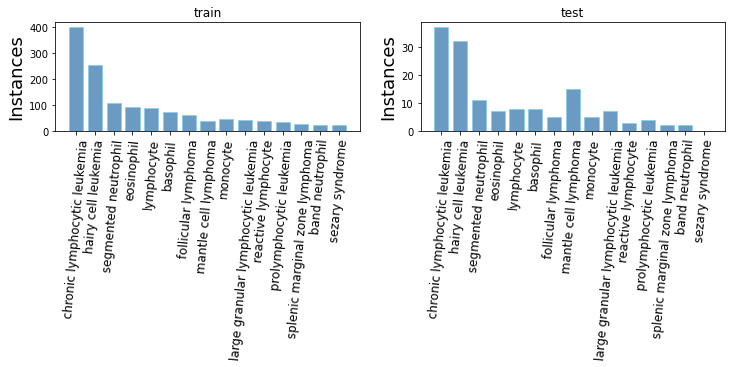

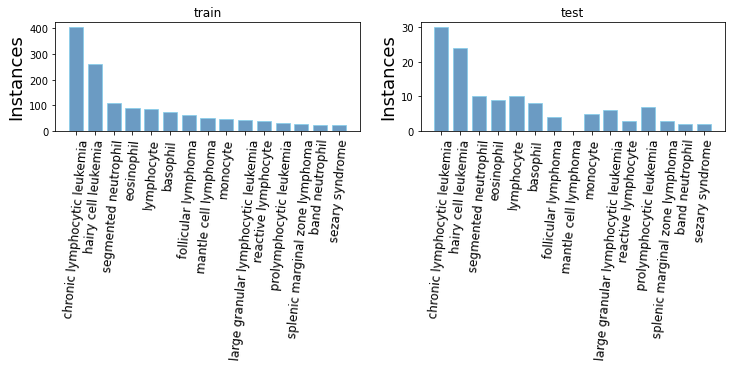

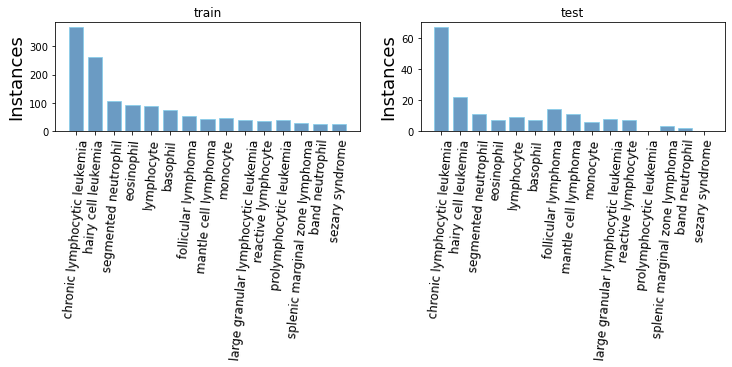

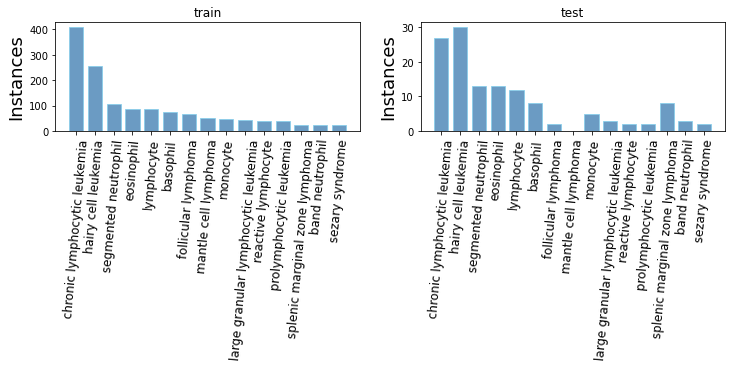

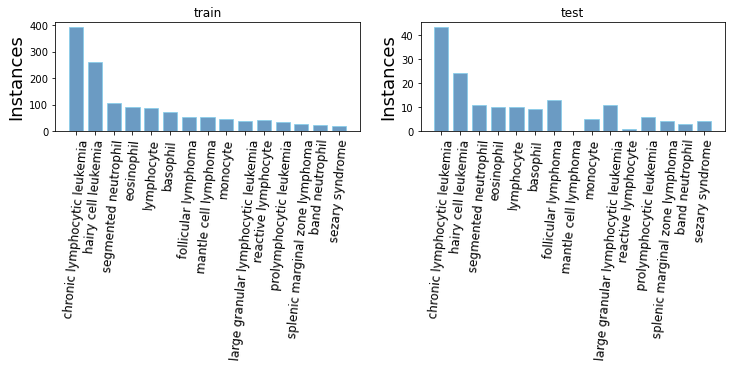

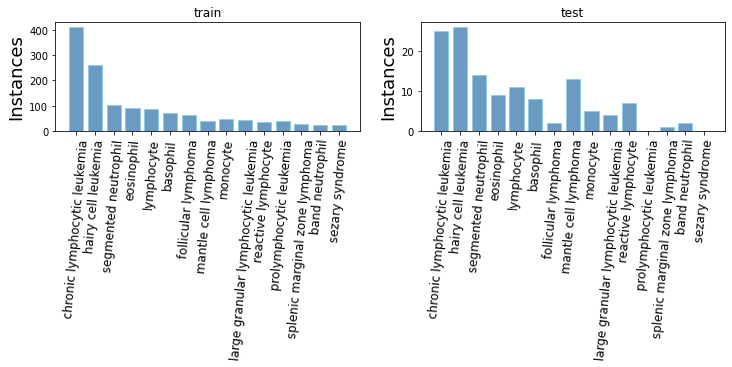

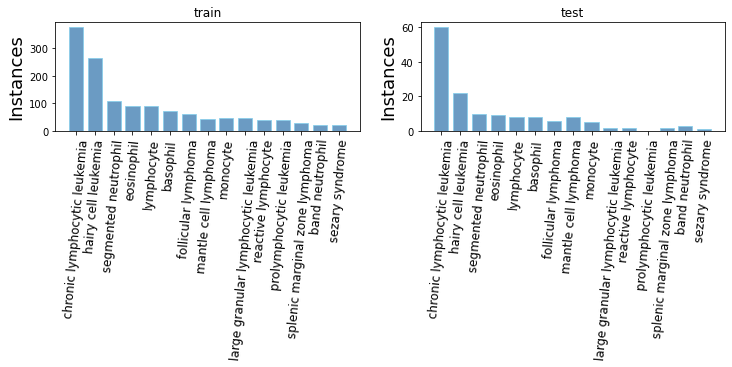

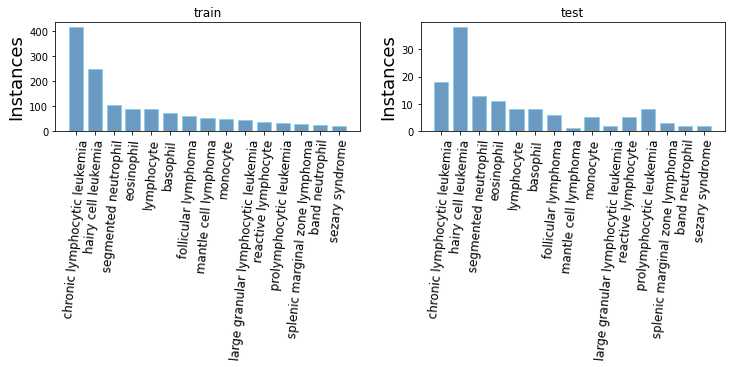

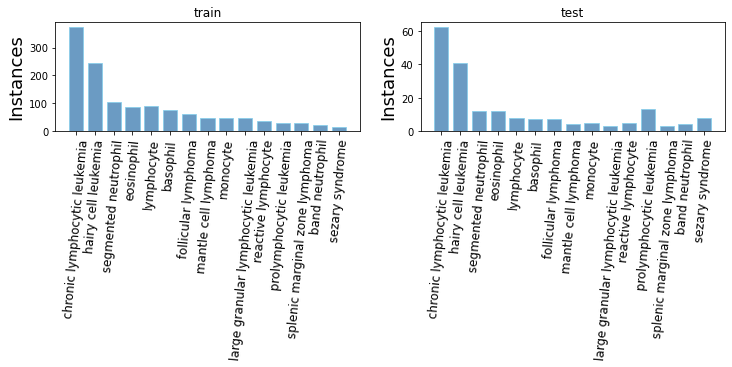

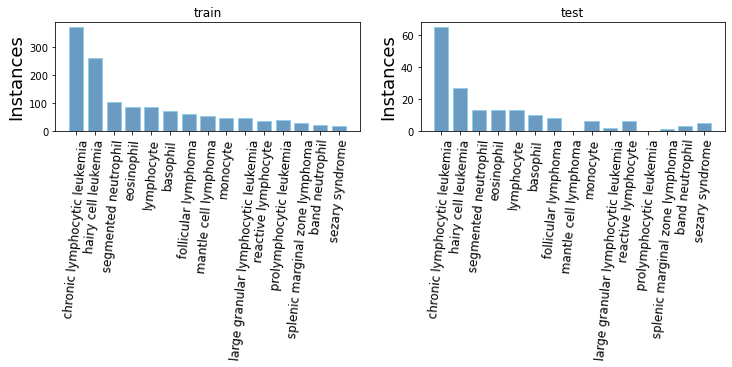

In [4]:
K = 10
k_fold = IterativeStratification(n_splits=K, order=1)
trains, tests = [], []

for train, test in k_fold.split(np.arange(len(img_files)), ind_dist):
    trains.append(train)
    tests.append(test)
    ins_dist_train = np.zeros((len(CLASS_NAMES),),dtype=np.float)
    ins_dist_test = np.zeros((len(CLASS_NAMES),),dtype=np.float)
    for sample in range(len(train)):
        ins_dist_train += ind_dist[train[sample],:]
    for sample in range(len(test)):
        ins_dist_test += ind_dist[test[sample],:]
    plt.figure(figsize=(12,2))
    plt.subplot(1,2,1)
    plt.bar(np.arange(nc),ins_dist_train[idx],
       width=0.75,color='steelblue',alpha=0.8,edgecolor='skyblue')
    plt.ylabel('Instances', fontsize=18)
    plt.xticks(np.arange(nc), names, fontsize=12, 
               rotation=85) # when X tick labels are long
    plt.title('train')
    plt.subplot(1,2,2)
    plt.bar(np.arange(nc),ins_dist_test[idx],
       width=0.75,color='steelblue',alpha=0.8,edgecolor='skyblue')
    plt.ylabel('Instances', fontsize=18)
    plt.xticks(np.arange(nc), names, fontsize=12, 
               rotation=85) # when X tick labels are long
    plt.title('test')
    plt.show()
    

    

In [5]:
np.save('train_index_k10_pb.npy',trains,allow_pickle=True)
np.save('test_index_k10_pb.npy',tests,allow_pickle=True)

/nasdata/KHJ/.conda/envs/foryolo/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
